In [1]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from sklearn import tree
from IPython.display import Image
%matplotlib inline
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

### Gradient boosting

You may recall that we last encountered gradients when discussing the gradient descent algorithm in the context of fitting linear regression models.  For a particular regression model with n parameters, an n+1 dimensional space existed defined by all the parameters plus the cost/loss function to minimize.  The combination of parameters and loss function define a surface within the space.  The regression model is fitted by moving down the steepest 'downhill' gradient until we reach the lowest point of the surface, where all possible gradients are 'uphill.'  The final model is made up of the parameter estimates that define that location on the surface.

Throughout all iterations of the gradient descent algorithm for linear regression, one thing remains constant: The underlying data used to estimate the parameters and calculate the loss function never changes.  In gradient boosting, however, the underlying data do change.  

Each time we run a decision tree, we extract the residuals.  Then we run a new decision tree, using those residuals as the outcome to be predicted.  After reaching a stopping point, we add together the predicted values from all of the decision trees to create the final gradient boosted prediction.

Gradient boosting can work on any combination of loss function and model type, as long as we can calculate the derivatives of the loss function with respect to the model parameters.  Most often, however, gradient boosting uses decision trees, and minimizes either the  residual (regression trees) or the negative log-likelihood (classification trees).  

Let’s go through a simple regression example using Decision Trees as the base predictors (of course Gradient Boosting also works great with regression tasks). This is called Gradient Tree Boosting, or Gradient Boosted Regression Trees. First, let’s fit a `DecisionTreeRegressor` to the training set.

In [2]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [3]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now train a second `DecisionTreeRegressor` on the residual errors made by the first predictor:

In [4]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

Then we train a third regressor on the residual errors made by the second predictor:



In [5]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

Now we have an ensemble containing three trees. It can make predictions on a new instance simply by adding up the predictions of all the trees:

In [6]:
X_new = np.array([[0.8]])

In [7]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [8]:
y_pred

array([0.75026781])

The figure below represents the predictions of these three trees in the left column, and the ensemble’s predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

**<font color='teal'>Run the below cell to develop a visual representation.</font>**

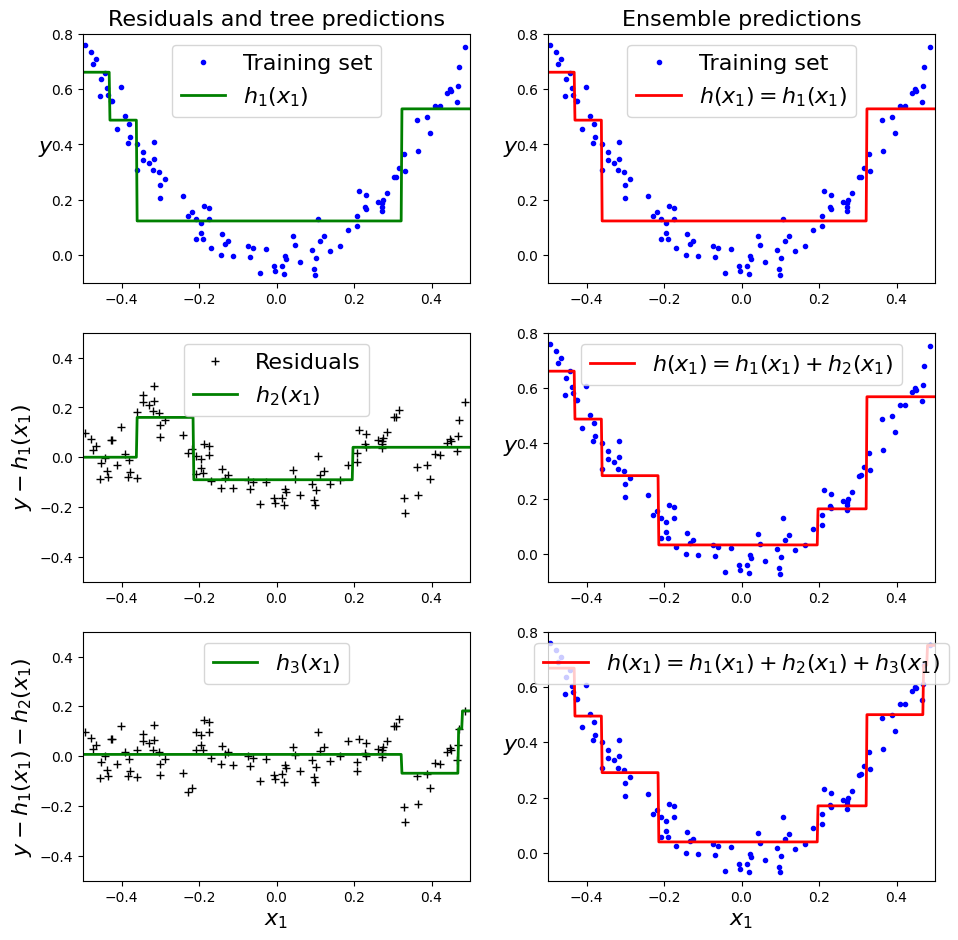

In [9]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

#save_fig("gradient_boosting_plot")
plt.show()

Now that you have solid understanding of Gradient Boosting in the regression scenario, let's apply the same algorithm to a classification problem. Specifically, the Titanic dataset and predicting survival.

**<font color='teal'>Use pandas read csv to load in the Titantic data set into a dataframe called df.</font>**

Hint: in this case you can use [dropna()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) to just throw away any incomplete rows. For the purpose of this exercise we will disregard them but obviously in the real world you need to be much more careful and decide how to handle incomplete observations.

In [11]:
df = pd.read_csv('/content/titanic.csv')
# Drop rows with missing values
df = df.dropna()

# Display the shape and the first few rows of data frame
print(f"DataFrame shape after dropping NA: {df.shape}")
print(df.head())

DataFrame shape after dropping NA: (183, 12)
    PassengerId  Survived  Pclass  \
1             2         1       1   
3             4         1       1   
6             7         0       1   
10           11         1       3   
11           12         1       1   

                                                 Name     Sex   Age  SibSp  \
1   Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
3        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
6                             McCarthy, Mr. Timothy J    male  54.0      0   
10                    Sandstrom, Miss. Marguerite Rut  female   4.0      1   
11                           Bonnell, Miss. Elizabeth  female  58.0      0   

    Parch    Ticket     Fare Cabin Embarked  
1       0  PC 17599  71.2833   C85        C  
3       0    113803  53.1000  C123        S  
6       0     17463  51.8625   E46        S  
10      1   PP 9549  16.7000    G6        S  
11      0    113783  26.5500  C10

**<font color='teal'>Print the levels of the categorical data using 'select_dtypes'. </font>**

In [12]:

# Select categorical columns from the DataFrame
categorical_columns = df.select_dtypes(include=['object']).columns

# Print the unique values (levels) for each categorical column
for col in categorical_columns:
    print(f"Levels for {col}:")
    print(df[col].unique())
    print("-" * 50)

Levels for Name:
['Cumings, Mrs. John Bradley (Florence Briggs Thayer)'
 'Futrelle, Mrs. Jacques Heath (Lily May Peel)' 'McCarthy, Mr. Timothy J'
 'Sandstrom, Miss. Marguerite Rut' 'Bonnell, Miss. Elizabeth'
 'Beesley, Mr. Lawrence' 'Sloper, Mr. William Thompson'
 'Fortune, Mr. Charles Alexander'
 'Harper, Mrs. Henry Sleeper (Myna Haxtun)'
 'Ostby, Mr. Engelhart Cornelius' 'Harris, Mr. Henry Birkhardt'
 'Nye, Mrs. (Elizabeth Ramell)' 'Moen, Mr. Sigurd Hansen'
 'Fortune, Miss. Mabel Helen' 'Chaffee, Mr. Herbert Fuller'
 'Goldschmidt, Mr. George B' 'Greenfield, Mr. William Bertram'
 'White, Mr. Richard Frasar' 'Porter, Mr. Walter Chamberlain'
 'Baxter, Mr. Quigg Edmond' 'Webber, Miss. Susan'
 'White, Mr. Percival Wayland' 'Newsom, Miss. Helen Monypeny'
 'Futrelle, Mr. Jacques Heath' 'Giglio, Mr. Victor'
 'Navratil, Mr. Michel ("Louis M Hoffman")'
 'Pears, Mrs. Thomas (Edith Wearne)' 'Van der hoef, Mr. Wyckoff'
 'Smith, Mr. James Clinch' 'Isham, Miss. Ann Elizabeth'
 'Becker, Master. Rich

**<font color='teal'>Create dummy features for the categorical features and add those to the 'df' dataframe. Make sure to also remove the original categorical columns from the dataframe.</font>**

In [14]:

# Drop unnecessary categorical columns and create dummy variables for the remaining categorical features
df = pd.get_dummies(df.drop(['Name', 'Cabin', 'Ticket', 'PassengerId'], axis=1), drop_first=True)

# Display the shape and the first few rows of the transformed DataFrame
print(f"DataFrame shape after encoding: {df.shape}")
print(df.head())

DataFrame shape after encoding: (183, 9)
    Survived  Pclass   Age  SibSp  Parch     Fare  Sex_male  Embarked_Q  \
1          1       1  38.0      1      0  71.2833     False       False   
3          1       1  35.0      1      0  53.1000     False       False   
6          0       1  54.0      0      0  51.8625      True       False   
10         1       3   4.0      1      1  16.7000     False       False   
11         1       1  58.0      0      0  26.5500     False       False   

    Embarked_S  
1        False  
3         True  
6         True  
10        True  
11        True  


**<font color='teal'>Print the null values for each column in the dataframe.</font>**

In [15]:
# Check for null values in each column
null_counts = df.isnull().sum()

# Print the null values for each column
print("Null values in each column:")
print(null_counts)

Null values in each column:
Survived      0
Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_male      0
Embarked_Q    0
Embarked_S    0
dtype: int64


**<font color='teal'>Create the X and y matrices from the dataframe, where y = df.Survived </font>**

In [17]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']
#Display shapes for verification
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

Shape of X: (183, 8)
Shape of y: (183,)


**<font color='teal'>Apply the standard scaler to the X matrix.</font>**

In [18]:
#Import StandarScaler
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler().fit(X)

# Scale the X matrix
X_scaled = scaler.transform(X)

# Convert the scaled data back to a DataFrame for easier inspection
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Display the shape and first few rows of the scaled matrix
print(f"Shape of X_scaled: {X_scaled.shape}")
print(X_scaled.head())

Shape of X_scaled: (183, 8)
     Pclass       Age     SibSp     Parch      Fare  Sex_male  Embarked_Q  \
0 -0.372256  0.149065  0.833628 -0.631730 -0.097180 -1.039012   -0.105118   
1 -0.372256 -0.043230  0.833628 -0.631730 -0.335997 -1.039012   -0.105118   
2 -0.372256  1.174636 -0.723044 -0.631730 -0.352250  0.962453   -0.105118   
3  3.520480 -2.030273  0.833628  0.697081 -0.814070 -1.039012   -0.105118   
4 -0.372256  1.431029 -0.723044 -0.631730 -0.684702 -1.039012   -0.105118   

   Embarked_S  
0   -1.315805  
1    0.759991  
2    0.759991  
3    0.759991  
4    0.759991  


**<font color='teal'>Split the X_scaled and y into 75/25 training and testing data subsets..</font>**

In [19]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

# Print the shapes of the resulting datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (137, 8)
X_test shape: (46, 8)
y_train shape: (137,)
y_test shape: (46,)


**<font color='teal'>Run the cell below to test multiple learning rates in your gradient boosting classifier.</font>**

In [20]:
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    gb = GradientBoostingClassifier(n_estimators=20, learning_rate = learning_rate, max_features=2, max_depth = 2, random_state = 0)
    gb.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb.score(X_train, y_train)))
    print("Accuracy score (validation): {0:.3f}".format(gb.score(X_test, y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.781
Accuracy score (validation): 0.783

Learning rate:  0.1
Accuracy score (training): 0.803
Accuracy score (validation): 0.804

Learning rate:  0.25
Accuracy score (training): 0.839
Accuracy score (validation): 0.826

Learning rate:  0.5
Accuracy score (training): 0.898
Accuracy score (validation): 0.783

Learning rate:  0.75
Accuracy score (training): 0.920
Accuracy score (validation): 0.783

Learning rate:  1
Accuracy score (training): 0.956
Accuracy score (validation): 0.761



**<font color='teal'>Apply the best learning rate to the model fit and predict on the testing set. Print out the confusion matrix and the classification report to review the model performance.</font>**

In [21]:

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize the Gradient Boosting Classifier with the best learning rate
best_lr = 0.25
model = GradientBoostingClassifier(learning_rate=best_lr, random_state=42)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict on the testing data
y_pred = model.predict(X_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[12  3]
 [ 5 26]]

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        15
           1       0.90      0.84      0.87        31

    accuracy                           0.83        46
   macro avg       0.80      0.82      0.81        46
weighted avg       0.83      0.83      0.83        46



**<font color='teal'>Calculate the ROC for the model as well.</font>**

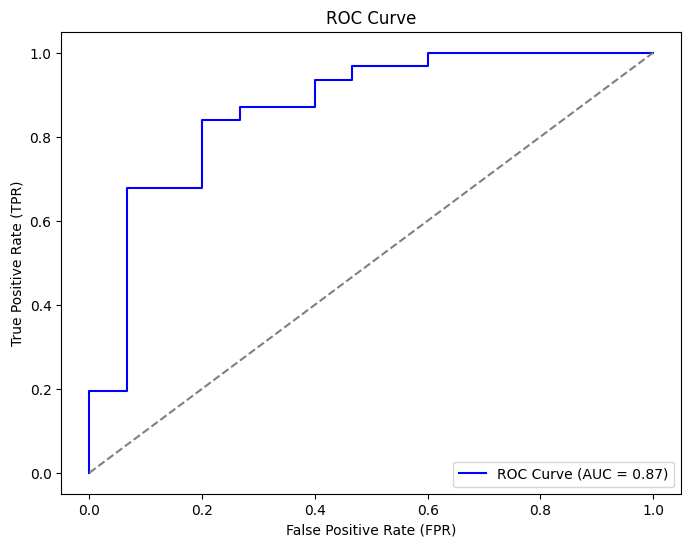

In [22]:

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Predict probabilities for the positive class
y_proba = model.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

# Calculate AUC score
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.show()